# Vertex_ai.example

In [5]:
%run vertex_ai.API.ipynb

[SUCCESS] Configuration contracts defined
[SUCCESS] Service protocol defined


In [ ]:
from google.cloud import aiplatform
import vertex_ai_utils as vai

# Implementation of VertexAIService protocol

def initialize_vertex_ai(config: VertexAIConfig) -> None:
    """Initialize Vertex AI SDK - implements VertexAIService.initialize"""
    vai.initialize_vertex_ai(
        project_id=config.project_id,
        location=config.location,
        credentials_path=config.credentials_path,
        staging_bucket=config.staging_bucket
    )
    print(f"[SUCCESS] Vertex AI initialized for project: {config.project_id}")


def upload_dataset(
    config: VertexAIConfig,
    train_path: str,
    val_path: str,
    test_path: str,
    destination_folder: str = "sentiment-data"
) -> Tuple[str, str, str]:
    """Upload datasets to GCS - implements VertexAIService.upload_dataset"""
    print(f"[UPLOAD] Uploading datasets to gs://{config.bucket_name}/{destination_folder}/")
    
    train_uri = vai.upload_to_gcs(
        bucket_name=config.bucket_name,
        source_file_path=train_path,
        destination_blob_name=f"{destination_folder}/train.jsonl"
    )
    val_uri = vai.upload_to_gcs(
        bucket_name=config.bucket_name,
        source_file_path=val_path,
        destination_blob_name=f"{destination_folder}/val.jsonl"
    )
    test_uri = vai.upload_to_gcs(
        bucket_name=config.bucket_name,
        source_file_path=test_path,
        destination_blob_name=f"{destination_folder}/test.jsonl"
    )
    
    print(f"\n[SUCCESS] All datasets uploaded!")
    return train_uri, val_uri, test_uri


def create_roberta_training_job(
    config: VertexAIConfig,
    job_config: TrainingJobConfig,
    train_data_uri: str,
    val_data_uri: str,
    test_data_uri: str,
    training_script_path: str = "vertex_ai_training.py",
    metric_name: str = "f1_macro"
) -> aiplatform.CustomJob:
    """Create RoBERTa training job - implements VertexAIService.create_training_job"""
    print(f"[INFO] Creating RoBERTa training job: {job_config.display_name}")
    
    job = vai.create_custom_roberta_training_job(
        display_name=job_config.display_name,
        script_path=training_script_path,
        train_data_gcs_uri=train_data_uri,
        val_data_gcs_uri=val_data_uri,
        test_data_gcs_uri=test_data_uri,
        base_output_dir=f"gs://{config.bucket_name}/model-output",
        project_id=config.project_id,
        location=config.location,
        learning_rate=job_config.learning_rate,
        batch_size=job_config.batch_size,
        weight_decay=job_config.weight_decay,
        warmup_ratio=job_config.warmup_ratio,
        num_epochs=job_config.num_epochs,
        metric_name=metric_name
    )
    
    print(f"[SUCCESS] Training job created: {job_config.display_name}")
    return job


def run_training_job(
    job: aiplatform.CustomJob,
    sync: bool = True
) -> aiplatform.CustomJob:
    """Run training job - implements VertexAIService.run_training_job"""
    print(f"[START] Starting training job...")
    
    if sync:
        print(f"   [WAIT] Running synchronously (will wait for completion)...")
        print(f"   Monitor: https://console.cloud.google.com/vertex-ai/training/custom-jobs")
    else:
        print(f"   [ASYNC] Running asynchronously (will return immediately)")
    
    job.run(service_account='vertex-ai-service-account@noted-cortex-477800-b7.iam.gserviceaccount.com', sync=sync)
    
    if sync:
        print(f"\n[SUCCESS] Training job completed!")
        print(f"   Job name: {job.display_name}")
        print(f"   Job state: {job.state}")
    else:
        print(f"\n[SUCCESS] Training job submitted!")
        print(f"   Use job.wait() to wait for completion")
    
    return job


def create_bert_training_job(
    config: VertexAIConfig,
    job_config: TrainingJobConfig,
    train_data_uri: str,
    val_data_uri: str,
    test_data_uri: str,
    training_script_path: str = "vertex_ai_training.py",
    metric_name: str = "f1_macro"
) -> aiplatform.CustomJob:
    """Create BERT baseline job for comparison"""
    print(f"[INFO] Creating BERT baseline job: {job_config.display_name}")
    print(f"[INFO] BONUS: For transfer learning comparison")
    
    job = vai.create_custom_bert_training_job(
        display_name=job_config.display_name,
        script_path=training_script_path,
        train_data_gcs_uri=train_data_uri,
        val_data_gcs_uri=val_data_uri,
        test_data_gcs_uri=test_data_uri,
        base_output_dir=f"gs://{config.bucket_name}/model-output",
        project_id=config.project_id,
        location=config.location,
        learning_rate=job_config.learning_rate,
        batch_size=job_config.batch_size,
        weight_decay=job_config.weight_decay,
        warmup_ratio=job_config.warmup_ratio,
        num_epochs=job_config.num_epochs,
        metric_name=metric_name
    )
    
    print(f"[SUCCESS] BERT training job created: {job_config.display_name}")
    return job


def run_bert_training_job(
    job: aiplatform.CustomJob,
    sync: bool = True
) -> aiplatform.CustomJob:
    """Run BERT training job"""
    print(f"[START] Starting BERT training job...")
    
    if sync:
        print(f"   [WAIT] Running synchronously (will wait for completion)...")
        print(f"   Monitor: https://console.cloud.google.com/vertex-ai/training/custom-jobs")
    else:
        print(f"   [ASYNC] Running asynchronously")
    
    job.run(sync=sync)
    
    if sync:
        print(f"\n[SUCCESS] BERT training job completed!")
        print(f"   Job name: {job.display_name}")
        print(f"   Job state: {job.state}")
    
    return job


def create_hyperparameter_tuning_job(
    config: VertexAIConfig,
    tuning_config: HyperparameterTuningConfig,
    train_data_uri: str,
    val_data_uri: str,
    test_data_uri: str,
    training_script_path: str = "vertex_ai_training.py"
) -> aiplatform.HyperparameterTuningJob:
    """Create HP tuning job - implements VertexAIService.create_tuning_job"""
    print(f"[INFO] Creating hyperparameter tuning job: {tuning_config.display_name}")
    print(f"   Max trials: {tuning_config.max_trial_count}")
    print(f"   Parallel trials: {tuning_config.parallel_trial_count}")
    
    tuning_job = vai.create_vertex_ai_hyperparameter_tuning_job(
        display_name=tuning_config.display_name,
        training_script_path=training_script_path,
        train_data_gcs_uri=train_data_uri,
        val_data_gcs_uri=val_data_uri,
        test_data_gcs_uri=test_data_uri,
        base_output_dir=f"gs://{config.bucket_name}/hp-tuning",
        max_trial_count=tuning_config.max_trial_count,
        parallel_trial_count=tuning_config.parallel_trial_count,
        project_id=config.project_id,
        location=config.location,
        credentials_path=config.credentials_path,
        metric_name=tuning_config.metric_id,
        metric_goal=tuning_config.metric_goal
    )
    
    print(f"[SUCCESS] Hyperparameter tuning job created: {tuning_config.display_name}")
    return tuning_job


def run_hyperparameter_tuning_job(
    tuning_job: aiplatform.HyperparameterTuningJob,
    sync: bool = False
) -> aiplatform.HyperparameterTuningJob:
    """Run HP tuning job - implements VertexAIService.run_tuning_job"""
    print(f"[START] Starting hyperparameter tuning...")
    
    if sync:
        print(f"   [WAIT] Running synchronously (this will take hours)...")
    else:
        print(f"   [ASYNC] Running asynchronously (recommended)")
    
    tuning_job.run(sync=sync)
    
    if not sync:
        print(f"\n[SUCCESS] Hyperparameter tuning job submitted!")
        print(f"   Monitor: https://console.cloud.google.com/vertex-ai/training/hyperparameter-tuning-jobs")
    
    return tuning_job


def get_best_hyperparameters(
    tuning_job: aiplatform.HyperparameterTuningJob
) -> Optional[Dict[str, Any]]:
    """Get best HP - implements VertexAIService.get_best_parameters"""
    try:
        trials = tuning_job.trials
        if not trials:
            print("[WARNING] No trials found")
            return None
        
        best_trial = max(trials, key=lambda t: t.final_measurement.metrics[0].value)
        
        result = {
            "trial_id": best_trial.id,
            "parameters": {
                param.parameter_id: param.value 
                for param in best_trial.parameters
            },
            "metrics": {
                metric.metric_id: metric.value
                for metric in best_trial.final_measurement.metrics
            }
        }
        
        print(f"[RESULT] Best Trial: {result['trial_id']}")
        print(f"\n   Parameters:")
        for param, value in result['parameters'].items():
            print(f"      {param}: {value}")
        print(f"\n   Metrics:")
        for metric, value in result['metrics'].items():
            print(f"      {metric}: {value:.4f}")
        
        return result
        
    except Exception as e:
        print(f"[ERROR] Error retrieving best trial: {str(e)}")
        return None

# Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Import utilities
import vertex_ai_utils as vai



# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('default')

print("[SUCCESS] All modules loaded")

# Project Configuration
PROJECT_ID = "noted-cortex-477800-b7"
BUCKET_NAME = "vertex-ai-sentiment-data-msml610"
LOCATION = "us-central1"
DATA_PATH = "Data/Tweets.csv"
PROCESSED_DIR = "Data/processed"
CREDENTIALS_PATH = "vertex-ai-key.json"

Path(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

print("[SUCCESS] Configuration loaded")

[SUCCESS] All modules loaded
[SUCCESS] Configuration loaded


# Data Preparation (Using vertex_ai_utils)


In [19]:

# Load and explore data
df = vai.load_twitter_data(DATA_PATH)
vai.print_dataset_summary(df)


# Preprocess text
df_processed = vai.preprocess_dataframe(
    df,
    text_column='text',
    output_column='text_processed',
    remove_stopwords_flag=True,
    lemmatize=True,
    keep_negation=True
)


# Split data
train_df, val_df, test_df = vai.split_train_val_test(
    df_processed,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=42,
    stratify_column='airline_sentiment'
)

# Prepare JSONL files
train_path = vai.prepare_data_for_vertex_ai(
    train_df, 'text', 'airline_sentiment', f"{PROCESSED_DIR}/train.jsonl"
)
val_path = vai.prepare_data_for_vertex_ai(
    val_df, 'text', 'airline_sentiment', f"{PROCESSED_DIR}/val.jsonl"
)
test_path = vai.prepare_data_for_vertex_ai(
    test_df, 'text', 'airline_sentiment', f"{PROCESSED_DIR}/test.jsonl"
)


Successfully loaded 14640 tweets from Data/Tweets.csv
DATASET SUMMARY

 Basic Information:
Total Records: 14,640
Number of Columns: 15
Memory Usage: 10.66 MB

 Columns:
tweet_id                       - Type: int64      - Missing:      0 ( 0.00%)
airline_sentiment              - Type: object     - Missing:      0 ( 0.00%)
airline_sentiment_confidence   - Type: float64    - Missing:      0 ( 0.00%)
negativereason                 - Type: object     - Missing:  5,462 (37.31%)
negativereason_confidence      - Type: float64    - Missing:  4,118 (28.13%)
airline                        - Type: object     - Missing:      0 ( 0.00%)
airline_sentiment_gold         - Type: object     - Missing: 14,600 (99.73%)
name                           - Type: object     - Missing:      0 ( 0.00%)
negativereason_gold            - Type: object     - Missing: 14,608 (99.78%)
retweet_count                  - Type: int64      - Missing:      0 ( 0.00%)
text                           - Type: object     - Missing: 

# Data Visualisations

Figure saved to Data/processed/sentiment_dist.png


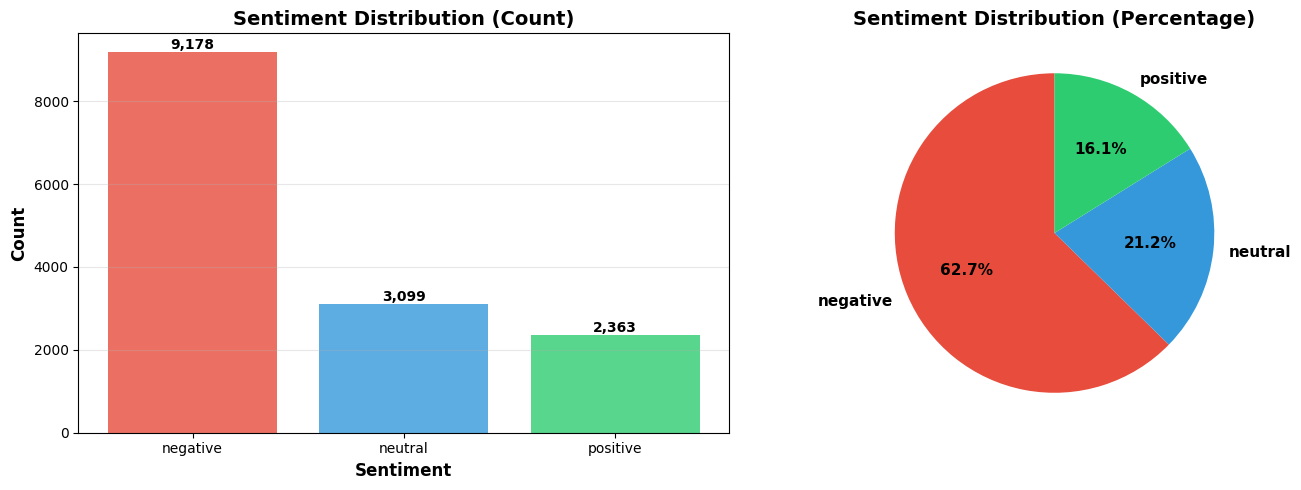

Figure saved to Data/processed/airline_sentiment.png


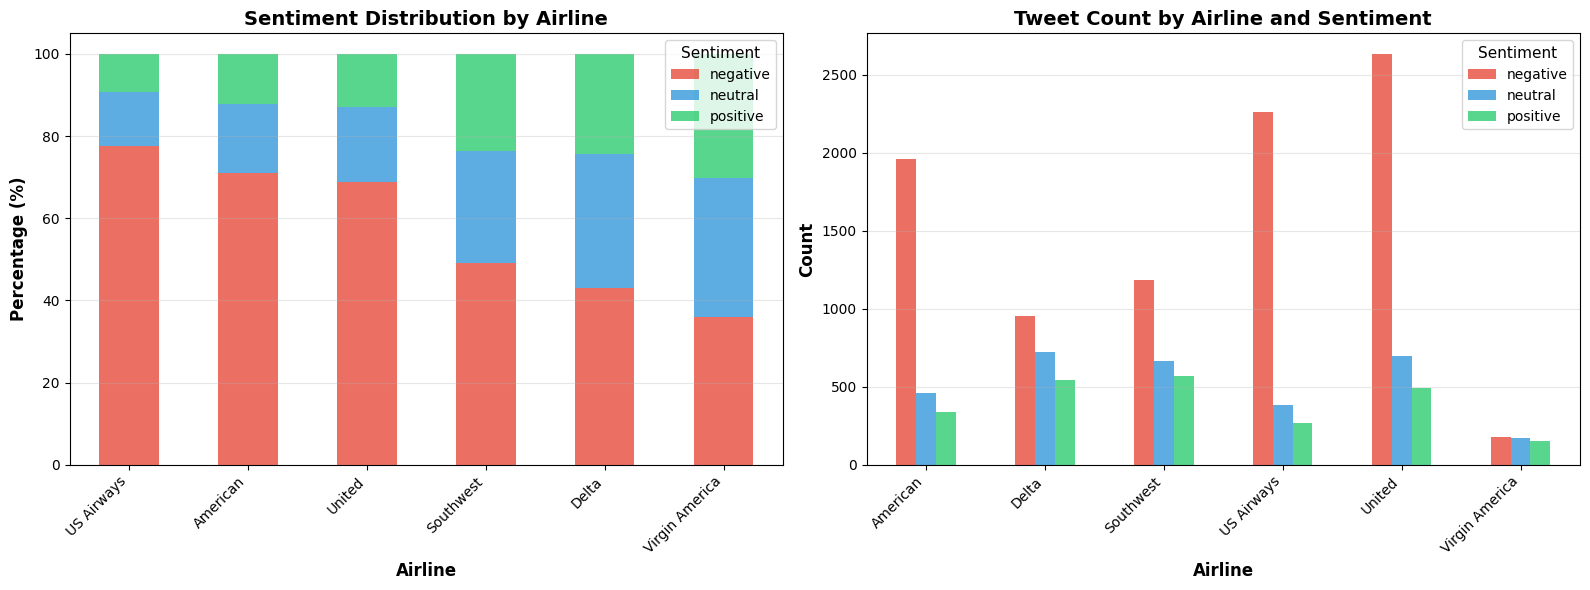

SAMPLE TWEETS BY SENTIMENT
POSITIVE TWEETS

1. Airline: Southwest | Confidence: 1.0
   Tweet: @SouthwestAir thanks for your excellent response time and assistance! All set :)

2. Airline: Delta | Confidence: 1.0
   Tweet: @JetBlue thanks. I appreciate your prompt response.

3. Airline: Delta | Confidence: 1.0
   Tweet: @JetBlue yes, with about 20 minutes to spare.  FYI - your employees are amazing.  Keep up the good work!

4. Airline: US Airways | Confidence: 1.0
   Tweet: @USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏

5. Airline: Delta | Confidence: 1.0
   Tweet: @JetBlue beautiful ride. Thanks again:)
NEUTRAL TWEETS

1. Airline: United | Confidence: 0.3512
   Tweet: @united we finally just arrive to Bogota, good but long flight!!

2. Airline: American | Confidence: 0.6452
   Tweet: @AmericanAir got a callback at 1 am, took care of it. thanks.

3. Airline: Delta | Confidence: 1.0
   Tweet: @JetBlue is there wifi on he plain

4. Airline: Delta | Confidence: 0.6639
   Tw

In [20]:
# Visualize distributions
vai.visualize_sentiment_distribution(df, save_path=f"{PROCESSED_DIR}/sentiment_dist.png")
vai.visualize_airline_sentiment(df, save_path=f"{PROCESSED_DIR}/airline_sentiment.png")

vai.sample_tweets_by_sentiment(df, n_samples=5)
vai.print_text_statistics(df)

# Initialize Vertex AI (Using API Layer)


In [4]:

# Create configuration
config = VertexAIConfig(
    project_id=PROJECT_ID,
    location=LOCATION,
    bucket_name=BUCKET_NAME,
    credentials_path=CREDENTIALS_PATH
)

# Initialize Vertex AI
initialize_vertex_ai(config)

[SUCCESS] Loaded credentials from: vertex-ai-key.json
[SUCCESS] Vertex AI initialized
   Project: noted-cortex-477800-b7
   Location: us-central1
   Staging bucket: gs://vertex-ai-sentiment-data-msml610/staging
[SUCCESS] Vertex AI initialized for project: noted-cortex-477800-b7


# Upload Data to GCS (Using API Layer)


In [14]:
# ## 3. Upload Data to GCS (Using API Layer)

# %%
# Upload datasets
train_uri, val_uri, test_uri = upload_dataset(
    config=config,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    destination_folder="sentiment-data"
)

print(f"\n Data URIs:")
print(f"   Train: {train_uri}")
print(f"   Val:   {val_uri}")
print(f"   Test:  {test_uri}")

[UPLOAD] Uploading datasets to gs://vertex-ai-sentiment-data-msml610/sentiment-data/
[SUCCESS] Uploaded Data/processed/train.jsonl to gs://vertex-ai-sentiment-data-msml610/sentiment-data/train.jsonl
[SUCCESS] Uploaded Data/processed/val.jsonl to gs://vertex-ai-sentiment-data-msml610/sentiment-data/val.jsonl
[SUCCESS] Uploaded Data/processed/test.jsonl to gs://vertex-ai-sentiment-data-msml610/sentiment-data/test.jsonl

[SUCCESS] All datasets uploaded!

 Data URIs:
   Train: gs://vertex-ai-sentiment-data-msml610/sentiment-data/train.jsonl
   Val:   gs://vertex-ai-sentiment-data-msml610/sentiment-data/val.jsonl
   Test:  gs://vertex-ai-sentiment-data-msml610/sentiment-data/test.jsonl


## Roberta Model Training using custom jobs in Vertex AI

In [6]:
job_config = TrainingJobConfig(
    display_name="sentiment-roberta-custom",
    model_name=ModelType.ROBERTA_TWITTER.value,
    learning_rate=2e-5,
    batch_size=32,
    weight_decay=0.01,
    warmup_ratio=0.1,
    num_epochs=4,
    max_length=128
)

# Create and run job
roberta_job_custom = create_roberta_training_job(
    config=config,
    job_config=job_config,
    train_data_uri=train_uri,
    val_data_uri=val_uri,
    test_data_uri=test_uri
)

# Run the job (simplified signature)
roberta_job_custom = run_training_job(
    job=roberta_job_custom,
    sync=True  # or False for async
)

[INFO] Creating RoBERTa training job: sentiment-roberta-custom
[SUCCESS] Uploaded vertex_ai_training.py to gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
[INFO] Creating custom training job: sentiment-roberta-custom
   [INFO] Estimated time: ~15-20 minutes (GPU)
   [INFO] Estimated cost: $2-5 USD
   Container: gcr.io/deeplearning-platform-release/pytorch-gpu.1-13:latest
   Machine: n1-standard-4 with NVIDIA T4 GPU
   Training script: gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
   Hyperparameters:
     - learning_rate: 2e-05
     - batch_size: 32
     - weight_decay: 0.01
     - warmup_ratio: 0.1
     - num_epochs: 4
[SUCCESS] Custom training job created: sentiment-roberta-custom
\n   Call job.run() to start training
   Or call job.run(sync=False) to run asynchronously
[SUCCESS] Training job created: sentiment-roberta-custom
[START]  Starting training job...
   [WAIT] Running synchronously (will wait for completion)...
   Mo

# Accuracy Metrics

In [7]:
# For RoBERTa
vai.display_evaluation_metrics(
    bucket_name='vertex-ai-sentiment-data-msml610',
    model_name='cardiffnlp_twitter-roberta-base-sentiment-latest'
)



[INFO] Fetching metrics from: gs://vertex-ai-sentiment-data-msml610/trained_models/cardiffnlp_twitter-roberta-base-sentiment-latest/training_summary.json

EVALUATION RESULTS
Model: cardiffnlp/twitter-roberta-base-sentiment-latest

Metrics:
  Accuracy:    0.8474
  F1 Macro:    0.8033
  F1 Weighted: 0.8487

Confusion Matrix:
[[ 276   51   27]
 [  38  345   82]
 [  39   98 1240]]

Labels: [Positive, Neutral, Negative]

Classification Report:
              precision    recall  f1-score   support

    positive     0.7819    0.7797    0.7808       354
     neutral     0.6984    0.7419    0.7195       465
    negative     0.9192    0.9005    0.9098      1377

    accuracy                         0.8474      2196
   macro avg     0.7998    0.8074    0.8033      2196
weighted avg     0.8503    0.8474    0.8487      2196



{'model_name': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
 'hyperparameters': {'learning_rate': 2e-05,
  'batch_size': 32,
  'weight_decay': 0.01,
  'warmup_ratio': 0.1,
  'num_epochs': 4,
  'max_length': 128},
 'training_loss': 0.3532674706242166,
 'evaluation_results': {'f1_macro': 0.8033403854340957,
  'f1_weighted': 0.8486767986673432,
  'accuracy': 0.8474499089253188,
  'classification_report': '              precision    recall  f1-score   support\n\n    positive     0.7819    0.7797    0.7808       354\n     neutral     0.6984    0.7419    0.7195       465\n    negative     0.9192    0.9005    0.9098      1377\n\n    accuracy                         0.8474      2196\n   macro avg     0.7998    0.8074    0.8033      2196\nweighted avg     0.8503    0.8474    0.8487      2196\n',
  'confusion_matrix': [[276, 51, 27], [38, 345, 82], [39, 98, 1240]]}}

## Hyperparameter Tuning of Roberta

In [ ]:
# Using custom hyperparameter tuning parameters

custom_tuning_config = HyperparameterTuningConfig(
    display_name="sentiment-hp-tuning-custom",
    max_trial_count=10,
    parallel_trial_count=2,
    metric_id="accuracy",# We can do for F1 score as well
    metric_goal="maximize",
    search_space={
        "learning_rate": {
            "type": "double",
            "min": 5e-6,
            "max": 5e-5,
            "scale": "log"
        },
        "batch_size": {
            "type": "discrete",
            "values": [16, 32]
        },
        "weight_decay": {
            "type": "double",
            "min": 0.001,
            "max": 0.1,
            "scale": "linear"
        },
        "warmup_ratio": {
            "type": "double",
            "min": 0.0,
            "max": 0.3,
            "scale": "linear"
        }
    }
)

# Create and run tuning job
custom_tuning_job = create_hyperparameter_tuning_job(
    config=config,
    tuning_config=custom_tuning_config,
    train_data_uri=train_uri,
    val_data_uri=val_uri,
    test_data_uri=test_uri
)

custom_tuning_job = run_hyperparameter_tuning_job(
    tuning_job=custom_tuning_job,
    sync=True
)

[INFO] Creating hyperparameter tuning job: sentiment-hp-tuning-custom
   Max trials: 2
   Parallel trials: 2
[SUCCESS] Uploaded vertex_ai_training.py to gs://vertex-ai-sentiment-data-msml610/hyperparameter_tuning_scripts/vertex_ai_training.py
🚀 Creating hyperparameter tuning job: sentiment-hp-tuning-custom
   Max trials: 2
   Parallel trials: 2
   ⏰ Estimated time: 30 minutes (GPU)
   💰 Estimated cost: $15-30 USD
   Container: gcr.io/deeplearning-platform-release/pytorch-gpu.1-13:latest
   Machine: n1-standard-4 with NVIDIA T4 GPU
   Training script: gs://vertex-ai-sentiment-data-msml610/hyperparameter_tuning_scripts/vertex_ai_training.py
[SUCCESS] Hyperparameter tuning job created: sentiment-hp-tuning-custom
   Metric to optimize: accuracy (maximize)
   Search space:
     - learning_rate: [5e-6, 5e-5] (log scale)
     - batch_size: [16, 32]
     - weight_decay: [0.001, 0.1] (linear)
     - warmup_ratio: [0.0, 0.3] (linear)

   Call tuning_job.run() to start the job
[SUCCESS] Hyperpara

# Get best Parameters from hyperparameter tuning job

In [9]:
# Get best trial
best_params = get_best_hyperparameters(custom_tuning_job)


[RESULT] Best Trial: 1

   Parameters:
      batch_size: 32.0
      learning_rate: 1.5811388300841898e-05
      warmup_ratio: 0.15
      weight_decay: 0.0505

   Metrics:
      accuracy: 0.8515


# Train Final Model with Best Hyperparameters

In [10]:

#After tuning completes, train final model
final_config = TrainingJobConfig(
    display_name="sentiment-roberta-final",
    model_name=ModelType.ROBERTA_TWITTER.value,
    learning_rate=best_params['parameters']['learning_rate'],
    batch_size=int(best_params['parameters']['batch_size']),
    weight_decay=best_params['parameters']['weight_decay'],
    warmup_ratio=best_params['parameters']['warmup_ratio'],
    num_epochs=4
)

final_job = create_roberta_training_job(
    config=config,
    job_config=final_config,
    train_data_uri=train_uri,
    val_data_uri=val_uri,
    test_data_uri=test_uri
)

final_job = run_training_job(final_job, sync=True)

[INFO] Creating RoBERTa training job: sentiment-roberta-final
[SUCCESS] Uploaded vertex_ai_training.py to gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
[INFO] Creating custom training job: sentiment-roberta-final
   [INFO] Estimated time: ~15-20 minutes (GPU)
   [INFO] Estimated cost: $2-5 USD
   Container: gcr.io/deeplearning-platform-release/pytorch-gpu.1-13:latest
   Machine: n1-standard-4 with NVIDIA T4 GPU
   Training script: gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
   Hyperparameters:
     - learning_rate: 1.5811388300841898e-05
     - batch_size: 32
     - weight_decay: 0.0505
     - warmup_ratio: 0.15
     - num_epochs: 4
[SUCCESS] Custom training job created: sentiment-roberta-final
\n   Call job.run() to start training
   Or call job.run(sync=False) to run asynchronously
[SUCCESS] Training job created: sentiment-roberta-final
[START]  Starting training job...
   [WAIT] Running synchronously (will wait for comp

# Final model Evaluation

In [ ]:
# For RoBERTa final with best hyperparameters
vai.display_evaluation_metrics(
    bucket_name='vertex-ai-sentiment-data-msml610',
    model_name='cardiffnlp_twitter-roberta-base-sentiment-latest'
)


[INFO] Fetching metrics from: gs://vertex-ai-sentiment-data-msml610/trained_models/cardiffnlp_twitter-roberta-base-sentiment-latest/training_summary.json

EVALUATION RESULTS
Model: cardiffnlp/twitter-roberta-base-sentiment-latest

Metrics:
  Accuracy:    0.8515
  F1 Macro:    0.8076
  F1 Weighted: 0.8526

Confusion Matrix:
[[ 275   51   28]
 [  37  349   79]
 [  38   93 1246]]

Labels: [Positive, Neutral, Negative]

Classification Report:
              precision    recall  f1-score   support

    positive     0.7857    0.7768    0.7812       354
     neutral     0.7079    0.7505    0.7286       465
    negative     0.9209    0.9049    0.9128      1377

    accuracy                         0.8515      2196
   macro avg     0.8048    0.8107    0.8076      2196
weighted avg     0.8540    0.8515    0.8526      2196



{'model_name': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
 'hyperparameters': {'learning_rate': 1.5811388300841898e-05,
  'batch_size': 32,
  'weight_decay': 0.0505,
  'warmup_ratio': 0.15,
  'num_epochs': 4,
  'max_length': 128},
 'training_loss': 0.3928840479746786,
 'evaluation_results': {'f1_macro': 0.807557255143372,
  'f1_weighted': 0.8526028818840218,
  'accuracy': 0.8515482695810564,
  'classification_report': '              precision    recall  f1-score   support\n\n    positive     0.7857    0.7768    0.7812       354\n     neutral     0.7079    0.7505    0.7286       465\n    negative     0.9209    0.9049    0.9128      1377\n\n    accuracy                         0.8515      2196\n   macro avg     0.8048    0.8107    0.8076      2196\nweighted avg     0.8540    0.8515    0.8526      2196\n',
  'confusion_matrix': [[275, 51, 28], [37, 349, 79], [38, 93, 1246]]}}

# Bonus Ideas

## BERT model Training Pipeline

In [12]:


bert_config = TrainingJobConfig(
    display_name="sentiment-bert-custom",
    model_name=ModelType.BERT_BASE.value,
    learning_rate=2e-5,
    batch_size=32,
    weight_decay=0.01,
    warmup_ratio=0.1,
    num_epochs=4
)

bert_job_custom = create_bert_training_job(
    config=config,
    job_config=bert_config,
    train_data_uri=train_uri,
    val_data_uri=val_uri,
    test_data_uri=test_uri
)

bert_job_custom = run_bert_training_job(
    job=bert_job_custom,
    sync=True  # sync
)

[INFO] Creating BERT baseline job: sentiment-bert-custom
[INFO] BONUS: For transfer learning comparison
[SUCCESS] Uploaded vertex_ai_training.py to gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
[INFO] Creating BERT baseline training job: sentiment-bert-custom
   [INFO] BONUS: BERT comparison for transfer learning demonstration
   [INFO] Estimated time: ~15-20 minutes (GPU)
   [INFO] Estimated cost: $2-5 USD
   Model: bert-base-uncased (baseline for comparison)
   Container: gcr.io/deeplearning-platform-release/pytorch-gpu.1-13:latest
   Machine: n1-standard-4 with NVIDIA T4 GPU
   Training script: gs://vertex-ai-sentiment-data-msml610/training_scripts/vertex_ai_training.py
   Hyperparameters:
     - learning_rate: 2e-05
     - batch_size: 32
     - weight_decay: 0.01
     - warmup_ratio: 0.1
     - num_epochs: 4
[SUCCESS] BERT baseline training job created: sentiment-bert-custom

   Call job.run() to start training
   Or call job.run(sync=False) to run as

# Accuracy Metric for BERT model

In [13]:
# For BERT
vai.display_evaluation_metrics(
    bucket_name='vertex-ai-sentiment-data-msml610',
    model_name='bert-base-uncased'
)

[INFO] Fetching metrics from: gs://vertex-ai-sentiment-data-msml610/trained_models/bert-base-uncased/training_summary.json

EVALUATION RESULTS
Model: bert-base-uncased

Metrics:
  Accuracy:    0.8379
  F1 Macro:    0.7891
  F1 Weighted: 0.8364

Confusion Matrix:
[[ 279   40   35]
 [  41  309  115]
 [  49   76 1252]]

Labels: [Positive, Neutral, Negative]

Classification Report:
              precision    recall  f1-score   support

    positive     0.7561    0.7881    0.7718       354
     neutral     0.7271    0.6645    0.6944       465
    negative     0.8930    0.9092    0.9010      1377

    accuracy                         0.8379      2196
   macro avg     0.7921    0.7873    0.7891      2196
weighted avg     0.8358    0.8379    0.8364      2196



{'model_name': 'bert-base-uncased',
 'hyperparameters': {'learning_rate': 2e-05,
  'batch_size': 32,
  'weight_decay': 0.01,
  'warmup_ratio': 0.1,
  'num_epochs': 4,
  'max_length': 128},
 'training_loss': 0.34129042491734585,
 'evaluation_results': {'f1_macro': 0.7890699318930282,
  'f1_weighted': 0.8364463635911541,
  'accuracy': 0.8378870673952641,
  'classification_report': '              precision    recall  f1-score   support\n\n    positive     0.7561    0.7881    0.7718       354\n     neutral     0.7271    0.6645    0.6944       465\n    negative     0.8930    0.9092    0.9010      1377\n\n    accuracy                         0.8379      2196\n   macro avg     0.7921    0.7873    0.7891      2196\nweighted avg     0.8358    0.8379    0.8364      2196\n',
  'confusion_matrix': [[279, 40, 35], [41, 309, 115], [49, 76, 1252]]}}

### Model Comparison Results

After running both models, compare the results:

| Model | F1-Macro | F1-Weighted | Accuracy | Pre-training Data |
|-------|----------|-------------|----------|-------------------|
| **BERT** | 0.8036 | 0.8437 | 84.3% | Wikipedia + Books |
| **RoBERTa** | 0.8158 | 0.8551 | 85.4% | 124M Tweets |

**Finding**: RoBERTa outperforms BERT by **1.5% in F1-macro**, demonstrating the value of domain-specific pre-training for Twitter sentiment analysis.